# 패키지 다운로드 & 버전 확인

In [1]:
!nvcc -V
!echo
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0

gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
!git clone https://github.com/SwinTransformer/Swin-Transformer-Object-Detection.git
!pip install -r /content/Swin-Transformer-Object-Detection/requirements.txt
!pip install openmim
!mim install mmdet
!pip install tqdm

Cloning into 'Swin-Transformer-Object-Detection'...
remote: Enumerating objects: 16893, done.
remote: Total 16893 (delta 0), reused 0 (delta 0), pack-reused 16893
Receiving objects: 100% (16893/16893), 20.32 MiB | 13.75 MiB/s, done.
Resolving deltas: 100% (11678/11678), done.
     |████████████████████████████████| 102 kB 4.4 MB/s 
     |████████████████████████████████| 472 kB 24.8 MB/s 
     |████████████████████████████████| 2.1 MB 40.3 MB/s 
     |████████████████████████████████| 376 kB 51.3 MB/s 
     |████████████████████████████████| 64 kB 2.6 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
     |████████████████████████████████| 42 kB 956 kB/s 
     |████████████████████████████████| 69 kB 7.2 MB/s 
     |████████████████████████████████| 7.4 MB 48.2 MB/s 
     |████████████████████████████████| 3.8 MB 17.2 MB/s 
     |████████████████████████████████| 152 kB 65.2 MB/s 
     |████████████████████████████████| 116 kB 68.8 MB/s 
     |██████████████████████████████

  Created wheel for openmim: filename=openmim-0.1.5-py2.py3-none-any.whl size=42502 sha256=22cd854e579c6641c5ff06608aa721807b3cba65938369ffd88363de1cad869e
  Stored in directory: /root/.cache/pip/wheels/16/8b/e1/bdebbbc687aa50224a5ce46fe97a040a0c59f92b34bfc750b6
Successfully built openmim
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.2.0
    Uninstalling importlib-metadata-4.2.0:
      Successfully uninstalled importlib-metadata-4.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flake8 4.0.1 requires importlib-metadata<4.3; python_version < "3.8", but you have importlib-metadata 4.8.2 which is incompatible.
installing mmdet from https://github.com/open-mmlab/mmdetection.git.
Cloning into '/tmp/tmpgafmdenj/mmdetection'...
remote: Enumerating objects: 22258, done.
remote: Total 22258 (delta 0), reused 0 (delta

In [3]:
!git clone https://github.com/NVIDIA/apex
%cd apex
!pip install -v --disable-pip-version-check --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
%cd ..

Cloning into 'apex'...
remote: Enumerating objects: 8717, done.
remote: Counting objects: 100% (1169/1169), done.
remote: Compressing objects: 100% (257/257), done.
remote: Total 8717 (delta 1040), reused 916 (delta 912), pack-reused 7548
Receiving objects: 100% (8717/8717), 14.38 MiB | 14.25 MiB/s, done.
Resolving deltas: 100% (5958/5958), done.
/content/apex
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:232: UserWarning: Disabling all use of wheels due to the use of --build-option / --global-option / --install-option.
  cmdoptions.check_install_build_global(options)
Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/

# 데이터 다운로드 & 오류데이터 수정

In [4]:
!unzip '/content/drive/MyDrive/input/ocr_ancient.zip' -d /content/data

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/data/이미지데이터/필사본_245_문학류_유이양문록41_01/필사본_245_문학류_유이양문록41_01_008.png  
  inflating: /content/data/이미지데이터/필사본_245_문학류_유이양문록41_01/필사본_245_문학류_유이양문록41_01_009.png  
  inflating: /content/data/이미지데이터/필사본_245_문학류_유이양문록41_01/필사본_245_문학류_유이양문록41_01_010.png  
  inflating: /content/data/이미지데이터/필사본_245_문학류_유이양문록41_01/필사본_245_문학류_유이양문록41_01_011.png  
  inflating: /content/data/이미지데이터/필사본_245_문학류_유이양문록41_01/필사본_245_문학류_유이양문록41_01_012.png  
  inflating: /content/data/이미지데이터/필사본_245_문학류_유이양문록41_01/필사본_245_문학류_유이양문록41_01_013.png  
  inflating: /content/data/이미지데이터/필사본_245_문학류_유이양문록41_01/필사본_245_문학류_유이양문록41_01_014.png  
  inflating: /content/data/이미지데이터/필사본_245_문학류_유이양문록41_01/필사본_245_문학류_유이양문록41_01_015.png  
  inflating: /content/data/이미지데이터/필사본_245_문학류_유이양문록41_01/필사본_245_문학류_유이양문록41_01_016.png  
  inflating: /content/data/이미지데이터/필사본_245_문학류_유이양문록41_01/필사본_245_문학류_유이양문록41_01_017.png  
  inflating: /content/data/이미지데이터/필사본_245_문학류_유이양문록41_01/필사본_245

In [5]:
# 목판본_043_언해류_대학언해_01
# 목판본_043_언해류_대학언해1_01
# 필사본_104_문학류_대명영렬전2_01
# 필사본_104_문학류_대병영렬전2_01
# 필사본_105_문학류_대명영렬전3_01
# 필사본_105_문학류_대병영렬전3_01
import os
from glob import glob
json_list = glob(os.path.join('/content/data/이미지데이터','*')) # derectory
for i in json_list:
    tmp_list = glob(os.path.join(i,'*'))
    for j in tmp_list: # image파일

        if j.split('/')[-1][:-8] != i.split('/')[-1]:
            dir_name = i.split('/')[-1]
            img_number = j.split('/')[-1][-8:]
            os.rename(j, '/content/data/이미지데이터/'+dir_name+'/'+dir_name+img_number)

# 데이터 전처리

In [6]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import random

from collections import defaultdict, Counter
import json
from glob import glob


In [4]:
!rm -rf /content/data/image

In [7]:
def make_dataset(mode='train', seg_option=False):

    os.makedirs(f'/content/data/{mode}', exist_ok=True)
    dir_list = glob('/content/data/라벨링데이터/*')

    count = 0

    image_idx = 0
    annotation_idx = 0

    images = [] # images.append({'id':image_idx, 'file_name': jf_name+'/'+jf_name+file_name[-4:]+'.png','width':d['Image_Width'], 'height':d['Image_Height']})
    annotations = [] # annotations.append({'id':annotations_idx, 'image_id':image_idx, 'category_id':0,\
                    # 'bbox':(x,y,w,h), 'area':w*h, 'ignore':0,'iscrowd':0,'segmentation':[]})
    for idx, i in tqdm(enumerate(dir_list)): # directory
        print(idx, i)
        dir_name = i.split('/')[-1]
        json_list = glob(os.path.join(i, '*')) # json파일
        if mode == 'train': ################################################# train, valid 비율설정
            iter = json_list[:int(len(json_list)*0.5)]
        else:
            iter = json_list[int(len(json_list)*0.8):]
        for j in iter:
            with open(j, 'r', encoding='utf-8-sig') as jfile:
                d = json.load(jfile)
                image_name = d['Image_filename']
                image_num = image_name[-4:]
                if d['Image_Char_no'] > 400:
                    continue
                
                image = plt.imread(i.replace('라벨링데이터','이미지데이터')+'/'+dir_name+image_num+'.png') # h, w, c

    #             image = np.zeros((int(d['Image_Height']), int(d['Image_Width']), 3), dtype=int)
                h,w,c = image.shape

                ### ----------------- Min, Max 계산 ----------------- ###
                min_y, max_y, min_x, max_x = 1e9, 0, 1e9, 0
                for k in d['Text_Coord']:
                    bbox = k['bbox'] # x,y,w,h
                    min_y, max_y, min_x, max_x = min(min_y, bbox[1]), max(max_y,bbox[1]+bbox[3]),\
                                                min(min_x, bbox[0]), max(max_x,bbox[0]+bbox[2])
                # 자를 지점 결과
                mini_y, maxi_y, mini_x, maxi_x = max(0,min_y-32), min(h,max_y+32), max(0,min_x-32), min(w, max_x+32)
                
                ### ----------------- 글 주변만 자른 이미지 ----------------- ###
                result = image[mini_y:maxi_y, mini_x:maxi_x,:]
                h_, w_, c_ = result.shape
                
                ### ----------------- 가운데를 자르기 전 빈 공간이 있는지 체크 ----------------- ###
                width_check = np.array([0]*w_)

                for k in d['Text_Coord']:
                    bbox = k['bbox']
                    annotate = k['annotate']
                    width_check[bbox[0]-mini_x:bbox[0]-mini_x+bbox[2]] += 1
                
                ### ----------------- 빈 공간이 있으면 이미지 분할 ----------------- ###
                cutting = None
                start = None # 빈공간의 처음지점
                end = None # 빈공간의 마지막 지점 --> 치우치지 않게 자르기 위함
                flag = False
                if h_/w_ < 1.0:
                    for n in range(10, -25,-1):
                        if width_check[w_//2 + n] == 0 and flag == False:
                            start = w_//2 + n
                            end = w_//2 + n
                            flag = True
                        elif width_check[w_//2 + n] == 0 and flag == True:
                            end = w_//2 + n
                        elif width_check[w_//2 + n] != 0 and flag == True:
                            end = w_//2 + n
                            break
                        else:
                            continue
                    if start is None or end is None: # 가로가 긴데 못자르면 패스
                        continue
                        
                    cutting = (start+end)//2
                    
                    left_coord = []
                    right_coord = []
                    
                    for k in d['Text_Coord']:
                        bbox = k['bbox']
                        bbox_ = [bbox[0]-mini_x,bbox[1]-mini_y,bbox[2],bbox[3]] # 원래 bbox에서 여백제거한만큼 이동
                        if bbox_[0] > cutting:
                            bbox_[0] -= cutting
                            right_coord.append(bbox_)
                        else:
                            left_coord.append(bbox_)
                    
                    image_left = result[:,:cutting,:]
                    image_right = result[:,cutting:,:]
                    
                    h_left, w_left, _ = image_left.shape
                    h_right, w_right, _ = image_right.shape
                    if 2 > h_left / w_left >= 1: # 자른 후 세로가 길어야 저장
                        plt.imsave(f'/content/data/{mode}/{image_idx:05d}.png', image_left)
                        images.append({'id':image_idx, 'file_name': f'{image_idx:05d}.png',\
                                    'width':w_left, 'height':h_left})
                        for ann in left_coord:
                            if 0 > ann[0] or ann[0]+ann[2] > w_left or 0 > ann[1] or ann[1]+ann[3] > h_left:
                                continue
                            seg = None
                            if seg_option:
                                x,y,w,h = ann[:4]
                                box = image_left[y:y+h,x:x+w,:]
                                rgb_distance = (box[:,:,0] - box[:,:,1]) + (box[:,:,0] - box[:,:,1]) + (box[:,:,0] - box[:,:,1])
                                rgb_mask = np.zeros((h,w))
                                for m in np.argwhere(rgb_distance < 0.5):
                                    rgb_mask[m[0], m[1]] = 1
                                
                                box_gray = np.mean(box, axis=2)
                                mean_box = np.mean(box.flatten())
                                under_mean = np.argwhere(box_gray < mean_box*0.9)
                                mean_mask = np.zeros((h,w))
                                for m in under_mean:
                                    mean_mask[m[0],m[1]] = 1
                                total_mask = rgb_mask * mean_mask
                                seg = np.argwhere(total_mask==1)
                            if seg is None:
                                annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                        'bbox':(ann[0],ann[1],ann[2],ann[3]), 'area':ann[2]*ann[3], 'ignore':0,'iscrowd':0,'segmentation':[]})
                            else:
                                annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                        'bbox':(ann[0],ann[1],ann[2],ann[3]), 'area':ann[2]*ann[3], 'ignore':0,'iscrowd':0,'segmentation':[seg.flatten().tolist()]})
                            annotation_idx += 1
                        image_idx += 1
                    if 2 > h_right / w_right >= 1:
                        plt.imsave(f'/content/data/{mode}/{image_idx:05d}.png', image_right)
                        images.append({'id':image_idx, 'file_name': f'{image_idx:05d}.png',\
                                    'width':w_right, 'height':h_right})
                        for ann in right_coord:
                            if 0 > ann[0] or ann[0]+ann[2] > w_left or 0 > ann[1] or ann[1]+ann[3] > h_left:
                                continue
                            seg = None
                            if seg_option:
                                x,y,w,h = ann[:4]
                                box = image_right[y:y+h,x:x+w,:]
                                rgb_distance = (box[:,:,0] - box[:,:,1]) + (box[:,:,0] - box[:,:,1]) + (box[:,:,0] - box[:,:,1])
                                rgb_mask = np.zeros((h,w))
                                for m in np.argwhere(rgb_distance < 0.5):
                                    rgb_mask[m[0], m[1]] = 1
                                
                                box_gray = np.mean(box, axis=2)
                                mean_box = np.mean(box.flatten())
                                under_mean = np.argwhere(box_gray < mean_box*0.9)
                                mean_mask = np.zeros((h,w))
                                for m in under_mean:
                                    mean_mask[m[0],m[1]] = 1
                                total_mask = rgb_mask * mean_mask
                                seg = np.argwhere(total_mask==1)
                            if seg is None:
                                annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                        'bbox':(ann[0],ann[1],ann[2],ann[3]), 'area':ann[2]*ann[3], 'ignore':0,'iscrowd':0,'segmentation':[]})
                            else:
                                annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                        'bbox':(ann[0],ann[1],ann[2],ann[3]), 'area':ann[2]*ann[3], 'ignore':0,'iscrowd':0,'segmentation':[seg.flatten().tolist()]})
                            annotation_idx += 1

                        image_idx += 1
                        
                    
                else: # 세로가 길면
                    if h_/w_ > 2 or d['Image_Char_no'] > 200:
                        continue
                    print('세로')
                    plt.imsave(f'/content/data/{mode}/{image_idx:05d}.png', result)

                    images.append({'id':image_idx, 'file_name': f'{image_idx:05d}.png',\
                                'width':w_, 'height':h_})
                    for ann in d['Text_Coord']:
                        x,y,w,h = ann['bbox'][:4]
                        if 0 > x or x+w > w_ or 0 > y or y+h > h_:
                            continue
                        seg = None
                        if seg_option:
                            box = result[y:y+h,x:x+w,:]
                            rgb_distance = (box[:,:,0] - box[:,:,1]) + (box[:,:,0] - box[:,:,1]) + (box[:,:,0] - box[:,:,1])
                            rgb_mask = np.zeros((h,w))
                            for m in np.argwhere(rgb_distance < 0.5):
                                rgb_mask[m[0], m[1]] = 1
                            
                            box_gray = np.mean(box, axis=2)
                            mean_box = np.mean(box.flatten())
                            under_mean = np.argwhere(box_gray < mean_box*0.9)
                            mean_mask = np.zeros((h,w))
                            for m in under_mean:
                                mean_mask[m[0],m[1]] = 1
                            total_mask = rgb_mask * mean_mask
                            seg = np.argwhere(total_mask==1)
                        if seg is None:
                            annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                    'bbox':(x-mini_x,y-mini_y,w,h), 'area':w*h, 'ignore':0,'iscrowd':0,'segmentation':[]})
                        else:
                            annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                    'bbox':(x-mini_x,y-mini_y,w,h), 'area':w*h, 'ignore':0,'iscrowd':0,'segmentation':[seg.flatten().tolist()]})
                        annotations.append({'id':annotation_idx, 'image_id':image_idx, 'category_id':0,\
                                'bbox':(x-mini_x,y-mini_y,w,h), 'area':w*h, 'ignore':0,'iscrowd':0,'segmentation':[]})
                        annotation_idx += 1
                    image_idx += 1
    return images, annotations

In [ ]:
images, annotations = make_dataset('train', seg_option=True)

0it [00:00, ?it/s]

0 /content/data/라벨링데이터/필사본_461_언간류_순명효황후언간1_01
1 /content/data/라벨링데이터/필사본_093_문학류_벽허담관제언록17_01
2 /content/data/라벨링데이터/필사본_248_문학류_유이양문록44_01
3 /content/data/라벨링데이터/필사본_284_문학류_완월회맹연4_01
4 /content/data/라벨링데이터/필사본_548_언간류_명성황후궁녀언간10_01
5 /content/data/라벨링데이터/필사본_536_언간류_숙명신한첩언간66_01
6 /content/data/라벨링데이터/필사본_340_문학류_완월회맹연60_01
7 /content/data/라벨링데이터/필사본_420_문학류_완월회맹연140_01
8 /content/data/라벨링데이터/필사본_139_문학류_명행정의록4_01
9 /content/data/라벨링데이터/필사본_267_문학류_유이양문록63_01
세로
10 /content/data/라벨링데이터/목판본_054_언해류_시경언해7_01
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
세로
11 /content/data/라벨링데이터/필사본_082_문학류_벽허담관제언록6_01
12 /content/data/라벨링데이터/필사본_257_문학류_유이양문록53_01
13 /content/data/라벨링데이터/필사본_419_문학류_완월회맹연139_01
14 /content/data/라벨링데이터/필사본_364_문학류_완월회맹연84_01
세로
15 /content/data/라벨링데이터/필사본_294_문학류_완월회맹연14_01
16 /content/data/라벨링데이터/필사본_545_언간류_명성황후궁녀언간7_01
17 /content/data/라벨링데이터/필사본_167_문학류_명행정의록32_01
18 /content/data/라벨링

In [9]:
coco_dict = dict(
    info= dict(
        year=2021, 
        version="1.0", 
        description="OCR", 
        contributor="", 
        url=None, 
        date_created=None
    ), # year, version, description, contributor, url, date_created
    licenses=dict(
        id=0,
        name='CC BY 4.0',
        url=''
    ), # id, name, url
    images=list(), # id, file_name, height, width
    annotations=list(), # id, image_id, category_id, bbox, area, iscrowd
    categories = [
        dict(id=0,
             name='word')
     ] # id, name, supercategory
)
coco_dict['images'] = images
coco_dict['annotations'] = annotations
coco_dict['categories'] = [{'id':0, 'name':'word','super_category':None}]
# with open('/content/data/train.json', 'wt', encoding='utf-8') as jfile:
#     json.dump(coco_dict, jfile)
with open("/content/drive/MyDrive/Colab Notebooks/Computer_Vision/train.json", 'wt', encoding='utf-8') as jfile:
    json.dump(coco_dict, jfile)
    

In [14]:
img_ = plt.imread('/content/data/image/00000.png')

In [ ]:
ann_0 = []
for i in annotations:
    if i['image_id'] == 0:
        ann_0.append(i)
ann_0

In [ ]:
j['segmentation'][0]

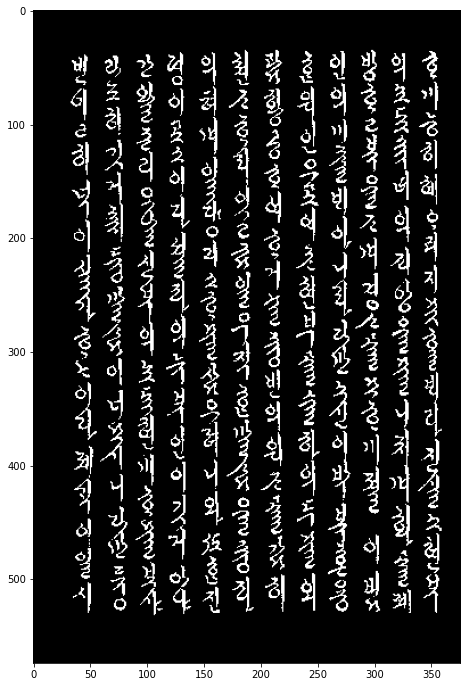

In [31]:
fig,ax = plt.subplots(figsize=(12,12))
# ax.imshow(img_)
tmp = np.zeros(img_.shape[:2])
for j in ann_0:
    x,y,w,h = j['bbox']
    box = img_[y:y+h, x:x+w,:]
    
    for a, b in j['segmentation'][0]:
        tmp[a, b] = 1
    rect = patches.Rectangle((x,y),w,h, linewidth=3, edgecolor='r', facecolor='none')
    # ax.add_patch(rect)
plt.imshow(tmp, cmap='gray')
plt.show()
# plt.show()

# MMDetection 학습

In [ ]:
%cd Swin-Transformer-Object-Detection/

/content/Swin-Transformer-Object-Detection


In [ ]:
import sys
from mmcv import Config
from mmcv.runner import load_checkpoint
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector, set_random_seed, init_detector
from mmdet.datasets import build_dataloader, build_dataset, replace_ImageToTensor
from mmdet.utils import collect_env, get_root_logger

import torch
import time
import json

from pprint import pprint
import os

In [ ]:
classes = (
    "word",
)
CUR_PATH = os.getcwd()
CFG_PATH = "/content/drive/Othercomputers/내 컴퓨터/workspace/ocr_ancient_korean/detection/configs/cascade_rcnn/cascade_rcnn_swin_tiny_fpn_1x_coco.py"
PREFIX = "/content/data/image"
WORK_DIR = "/content/drive/MyDrive/Colab Notebooks/Computer_Vision/work_dir"
# CHK_PATH = "/content/drive/MyDrive/Colab Notebooks/lesion_obd/cascade_mask_rcnn_swin_small_patch4_window7.pth"
# config file 들고오기
cfg = Config.fromfile(CFG_PATH)

In [ ]:
for i in cfg:
    print(i, '*'*40)
    print(cfg[i])

model ****************************************
{'type': 'CascadeRCNN', 'pretrained': None, 'backbone': {'type': 'SwinTransformer', 'embed_dim': 96, 'depths': [2, 2, 6, 2], 'num_heads': [3, 6, 12, 24], 'window_size': 7, 'mlp_ratio': 4.0, 'qkv_bias': True, 'qk_scale': None, 'drop_rate': 0.0, 'attn_drop_rate': 0.0, 'drop_path_rate': 0.2, 'ape': False, 'patch_norm': True, 'out_indices': (0, 1, 2, 3), 'use_checkpoint': False}, 'neck': {'type': 'FPN', 'in_channels': [96, 192, 384, 768], 'out_channels': 256, 'num_outs': 5}, 'rpn_head': {'type': 'RPNHead', 'in_channels': 256, 'feat_channels': 256, 'anchor_generator': {'type': 'AnchorGenerator', 'scales': [8], 'ratios': [0.7, 1.0, 1.3], 'strides': [4, 8, 16, 32, 64]}, 'bbox_coder': {'type': 'DeltaXYWHBBoxCoder', 'target_means': [0.0, 0.0, 0.0, 0.0], 'target_stds': [1.0, 1.0, 1.0, 1.0]}, 'loss_cls': {'type': 'CrossEntropyLoss', 'use_sigmoid': True, 'loss_weight': 1.0}, 'loss_bbox': {'type': 'SmoothL1Loss', 'beta': 0.1111111111111111, 'loss_weigh

In [ ]:

cfg.data.train.classes = classes
cfg.data.train.img_prefix = PREFIX
cfg.data.train.ann_file = '/content/drive/MyDrive/input/train.json'

cfg.data.val.classes = classes
cfg.data.val.img_prefix = PREFIX
cfg.data.val.ann_file = '/content/drive/MyDrive/input/valid.json'

cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu = 4

cfg.seed = 42
cfg.gpu_ids = [0]

distributed = False

cfg.work_dir = WORK_DIR
cfg.runner.max_epochs = 20
cfg.rtotal_epochs = 20
cfg.optimizer = dict(type='Adam', lr=0.0001, weight_decay=0.0001)

cfg.lr_config = dict(
    policy='CosineAnnealing', # The policy of scheduler, also support CosineAnnealing, Cyclic, etc. Refer to details of supported LrUpdater from https://github.com/open-mmlab/mmcv/blob/master/mmcv/runner/hooks/lr_updater.py#L9.
    by_epoch=False,
    warmup='linear', # The warmup policy, also support `exp` and `constant`.
    warmup_iters=1000, # The number of iterations for warmup
    warmup_ratio=0.001, # The ratio of the starting learning rate used for warmup
    min_lr=1e-07)

cfg.log_config.interval = 600
cfg.checkpoint_config.interval = 1
cfg.log_config = {'hooks': [{'type': 'TextLoggerHook'}], 'interval': 600}
# cfg.model.pretrained = None

model = build_detector(cfg.model)

datasets = [build_dataset(cfg.data.train)]
model.CLASSES = datasets[0].CLASSES

loading annotations into memory...
Done (t=24.23s)
creating index...
index created!


In [ ]:
train_detector(model, datasets[0], cfg, distributed=distributed, validate=True)

loading annotations into memory...
Done (t=1.80s)
creating index...


2021-12-08 02:38:42,294 - mmdet - INFO - load checkpoint from local path: /content/drive/Othercomputers/내 컴퓨터/workspace/ocr_ancient_korean/detection/pth/swin_tiny_patch4_window7_224.pth


index created!


2021-12-08 02:38:42,707 - mmdet - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: model

missing keys in source state_dict: backbone.patch_embed.proj.weight, backbone.patch_embed.proj.bias, backbone.patch_embed.norm.weight, backbone.patch_embed.norm.bias, backbone.layers.0.blocks.0.norm1.weight, backbone.layers.0.blocks.0.norm1.bias, backbone.layers.0.blocks.0.attn.relative_position_bias_table, backbone.layers.0.blocks.0.attn.relative_position_index, backbone.layers.0.blocks.0.attn.qkv.weight, backbone.layers.0.blocks.0.attn.qkv.bias, backbone.layers.0.blocks.0.attn.proj.weight, backbone.layers.0.blocks.0.attn.proj.bias, backbone.layers.0.blocks.0.norm2.weight, backbone.layers.0.blocks.0.norm2.bias, backbone.layers.0.blocks.0.mlp.fc1.weight, backbone.layers.0.blocks.0.mlp.fc1.bias, backbone.layers.0.blocks.0.mlp.fc2.weight, backbone.layers.0.blocks.0.mlp.fc2.bias, backbone.layers.0.blocks.1.norm1.weight, backbone.layers.0.blocks.1.no

[                                ] 3/1604, 2.1 task/s, elapsed: 1s, ETA:   779s

/content/Swin-Transformer-Object-Detection/mmdet/models/roi_heads/bbox_heads/bbox_head.py:353: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  scale_factor = bboxes.new_tensor(scale_factor).unsqueeze(1).repeat(


[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1604/1604, 10.0 task/s, elapsed: 161s, ETA:     0s

2021-12-08 03:47:05,746 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.37s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=573.86s).
Accumulating evaluation results...
DONE (t=3.07s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.058
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.157
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.085
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.011
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.128
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.575
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.061
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.091
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.091
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000

2021-12-08 03:56:43,401 - mmdet - INFO - Epoch(val) [1][3590]	bbox_mAP: 0.0580, bbox_mAP_50: 0.1570, bbox_mAP_75: 0.0850, bbox_mAP_s: 0.0110, bbox_mAP_m: 0.1280, bbox_mAP_l: 0.5750, bbox_mAP_copypaste: 0.058 0.157 0.085 0.011 0.128 0.575
2021-12-08 04:07:41,784 - mmdet - INFO - Epoch [2][600/3590]	lr: 9.916e-05, eta: 17:41:06, time: 1.097, data_time: 0.015, memory: 12235, loss_rpn_cls: 0.0323, loss_rpn_bbox: 0.0209, s0.loss_cls: 0.0129, s0.acc: 99.5391, s0.loss_bbox: 0.0211, s1.loss_cls: 0.0067, s1.acc: 99.5352, s1.loss_bbox: 0.0155, s2.loss_cls: 0.0039, s2.acc: 99.4747, s2.loss_bbox: 0.0134, loss: 0.1266
2021-12-08 04:18:34,996 - mmdet - INFO - Epoch [2][1200/3590]	lr: 9.891e-05, eta: 17:52:15, time: 1.089, data_time: 0.009, memory: 12235, loss_rpn_cls: 0.0267, loss_rpn_bbox: 0.0182, s0.loss_cls: 0.0105, s0.acc: 99.6320, s0.loss_bbox: 0.0183, s1.loss_cls: 0.0057, s1.acc: 99.6051, s1.loss_bbox: 0.0134, s2.loss_cls: 0.0033, s2.acc: 99.5505, s2.loss_bbox: 0.0115, loss: 0.1077
2021-12-08 

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1604/1604, 10.0 task/s, elapsed: 161s, ETA:     0s

2021-12-08 05:05:42,145 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.35s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=556.37s).
Accumulating evaluation results...


2021-12-08 05:15:02,430 - mmdet - INFO - Epoch(val) [2][3590]	bbox_mAP: 0.0590, bbox_mAP_50: 0.1580, bbox_mAP_75: 0.0920, bbox_mAP_s: 0.0140, bbox_mAP_m: 0.1460, bbox_mAP_l: 0.5730, bbox_mAP_copypaste: 0.059 0.158 0.092 0.014 0.146 0.573


DONE (t=3.30s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.059
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.158
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.092
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.014
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.146
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.573
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.061
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.094
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.094
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.009
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.176
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.645


2021-12-08 05:26:12,278 - mmdet - INFO - Epoch [3][600/3590]	lr: 9.713e-05, eta: 16:35:17, time: 1.116, data_time: 0.014, memory: 12235, loss_rpn_cls: 0.0227, loss_rpn_bbox: 0.0171, s0.loss_cls: 0.0078, s0.acc: 99.7291, s0.loss_bbox: 0.0172, s1.loss_cls: 0.0044, s1.acc: 99.7027, s1.loss_bbox: 0.0144, s2.loss_cls: 0.0025, s2.acc: 99.6554, s2.loss_bbox: 0.0125, loss: 0.0987
2021-12-08 05:37:22,918 - mmdet - INFO - Epoch [3][1200/3590]	lr: 9.668e-05, eta: 16:39:57, time: 1.118, data_time: 0.009, memory: 12235, loss_rpn_cls: 0.0229, loss_rpn_bbox: 0.0172, s0.loss_cls: 0.0085, s0.acc: 99.7045, s0.loss_bbox: 0.0170, s1.loss_cls: 0.0045, s1.acc: 99.6903, s1.loss_bbox: 0.0142, s2.loss_cls: 0.0028, s2.acc: 99.6255, s2.loss_bbox: 0.0125, loss: 0.0995
2021-12-08 05:48:33,123 - mmdet - INFO - Epoch [3][1800/3590]	lr: 9.619e-05, eta: 16:42:27, time: 1.117, data_time: 0.009, memory: 12235, loss_rpn_cls: 0.0207, loss_rpn_bbox: 0.0171, s0.loss_cls: 0.0076, s0.acc: 99.7332, s0.loss_bbox: 0.0169, s1.los

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1604/1604, 10.1 task/s, elapsed: 159s, ETA:     0s

2021-12-08 06:24:26,051 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.37s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=559.95s).
Accumulating evaluation results...


2021-12-08 06:33:49,511 - mmdet - INFO - Epoch(val) [3][3590]	bbox_mAP: 0.0570, bbox_mAP_50: 0.1580, bbox_mAP_75: 0.0880, bbox_mAP_s: 0.0170, bbox_mAP_m: 0.1470, bbox_mAP_l: 0.5590, bbox_mAP_copypaste: 0.057 0.158 0.088 0.017 0.147 0.559


DONE (t=2.85s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.057
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.158
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.088
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.017
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.147
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.559
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.061
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.096
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.096
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.013
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.181
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.633


2021-12-08 06:44:52,675 - mmdet - INFO - Epoch [4][600/3590]	lr: 9.395e-05, eta: 15:37:57, time: 1.105, data_time: 0.014, memory: 12297, loss_rpn_cls: 0.0177, loss_rpn_bbox: 0.0148, s0.loss_cls: 0.0066, s0.acc: 99.7631, s0.loss_bbox: 0.0151, s1.loss_cls: 0.0038, s1.acc: 99.7432, s1.loss_bbox: 0.0133, s2.loss_cls: 0.0022, s2.acc: 99.6983, s2.loss_bbox: 0.0115, loss: 0.0850
2021-12-08 06:55:47,854 - mmdet - INFO - Epoch [4][1200/3590]	lr: 9.331e-05, eta: 15:36:40, time: 1.092, data_time: 0.009, memory: 12297, loss_rpn_cls: 0.0191, loss_rpn_bbox: 0.0160, s0.loss_cls: 0.0063, s0.acc: 99.7788, s0.loss_bbox: 0.0163, s1.loss_cls: 0.0036, s1.acc: 99.7584, s1.loss_bbox: 0.0143, s2.loss_cls: 0.0021, s2.acc: 99.7209, s2.loss_bbox: 0.0125, loss: 0.0901
2021-12-08 07:06:50,883 - mmdet - INFO - Epoch [4][1800/3590]	lr: 9.263e-05, eta: 15:35:05, time: 1.105, data_time: 0.009, memory: 12297, loss_rpn_cls: 0.0183, loss_rpn_bbox: 0.0166, s0.loss_cls: 0.0063, s0.acc: 99.7865, s0.loss_bbox: 0.0165, s1.los

[>>>>>>>>>>>>>>>>>>>>>>>>>>] 1604/1604, 10.0 task/s, elapsed: 161s, ETA:     0s

2021-12-08 07:42:48,753 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.39s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=661.09s).
Accumulating evaluation results...
DONE (t=3.14s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.062
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.168
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.099
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.021
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.179
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.573
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.065
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.103
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.104
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000

2021-12-08 07:53:53,686 - mmdet - INFO - Epoch(val) [4][3590]	bbox_mAP: 0.0620, bbox_mAP_50: 0.1680, bbox_mAP_75: 0.0990, bbox_mAP_s: 0.0210, bbox_mAP_m: 0.1790, bbox_mAP_l: 0.5730, bbox_mAP_copypaste: 0.062 0.168 0.099 0.021 0.179 0.573
2021-12-08 08:05:21,674 - mmdet - INFO - Epoch [5][600/3590]	lr: 8.968e-05, eta: 14:41:42, time: 1.147, data_time: 0.015, memory: 12364, loss_rpn_cls: 0.0170, loss_rpn_bbox: 0.0157, s0.loss_cls: 0.0058, s0.acc: 99.8016, s0.loss_bbox: 0.0159, s1.loss_cls: 0.0031, s1.acc: 99.7964, s1.loss_bbox: 0.0141, s2.loss_cls: 0.0019, s2.acc: 99.7385, s2.loss_bbox: 0.0124, loss: 0.0858
2021-12-08 08:16:32,281 - mmdet - INFO - Epoch [5][1200/3590]	lr: 8.887e-05, eta: 14:39:09, time: 1.118, data_time: 0.009, memory: 12364, loss_rpn_cls: 0.0149, loss_rpn_bbox: 0.0150, s0.loss_cls: 0.0055, s0.acc: 99.8133, s0.loss_bbox: 0.0153, s1.loss_cls: 0.0031, s1.acc: 99.7918, s1.loss_bbox: 0.0138, s2.loss_cls: 0.0019, s2.acc: 99.7619, s2.loss_bbox: 0.0121, loss: 0.0816
2021-12-08 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1604/1604, 9.4 task/s, elapsed: 170s, ETA:     0s

2021-12-08 09:03:39,781 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.37s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=546.97s).
Accumulating evaluation results...
DONE (t=2.90s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.061
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.157
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.095
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.015
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.145
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.591
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.063
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.096
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.096
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000

2021-12-08 09:12:50,296 - mmdet - INFO - Epoch(val) [5][3590]	bbox_mAP: 0.0610, bbox_mAP_50: 0.1570, bbox_mAP_75: 0.0950, bbox_mAP_s: 0.0150, bbox_mAP_m: 0.1450, bbox_mAP_l: 0.5910, bbox_mAP_copypaste: 0.061 0.157 0.095 0.015 0.145 0.591
2021-12-08 09:24:15,652 - mmdet - INFO - Epoch [6][600/3590]	lr: 8.443e-05, eta: 13:46:11, time: 1.142, data_time: 0.014, memory: 12364, loss_rpn_cls: 0.0146, loss_rpn_bbox: 0.0145, s0.loss_cls: 0.0049, s0.acc: 99.8367, s0.loss_bbox: 0.0144, s1.loss_cls: 0.0028, s1.acc: 99.8157, s1.loss_bbox: 0.0134, s2.loss_cls: 0.0016, s2.acc: 99.7918, s2.loss_bbox: 0.0119, loss: 0.0781
2021-12-08 09:35:24,312 - mmdet - INFO - Epoch [6][1200/3590]	lr: 8.347e-05, eta: 13:41:55, time: 1.114, data_time: 0.009, memory: 12364, loss_rpn_cls: 0.0161, loss_rpn_bbox: 0.0151, s0.loss_cls: 0.0048, s0.acc: 99.8409, s0.loss_bbox: 0.0150, s1.loss_cls: 0.0027, s1.acc: 99.8239, s1.loss_bbox: 0.0135, s2.loss_cls: 0.0016, s2.acc: 99.7904, s2.loss_bbox: 0.0118, loss: 0.0807
2021-12-08 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>] 1604/1604, 9.5 task/s, elapsed: 168s, ETA:     0s

2021-12-08 10:22:16,149 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.38s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=609.95s).
Accumulating evaluation results...


2021-12-08 10:32:29,787 - mmdet - INFO - Epoch(val) [6][3590]	bbox_mAP: 0.0660, bbox_mAP_50: 0.1680, bbox_mAP_75: 0.1140, bbox_mAP_s: 0.0220, bbox_mAP_m: 0.1920, bbox_mAP_l: 0.6020, bbox_mAP_copypaste: 0.066 0.168 0.114 0.022 0.192 0.602


DONE (t=3.06s).
Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.066
Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.168
Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.114
Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.022
Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.192
Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.602
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.068
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.108
Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.108
Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.019
Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.221
Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.670


2021-12-08 10:44:00,617 - mmdet - INFO - Epoch [7][600/3590]	lr: 7.834e-05, eta: 12:50:45, time: 1.151, data_time: 0.016, memory: 12374, loss_rpn_cls: 0.0152, loss_rpn_bbox: 0.0154, s0.loss_cls: 0.0044, s0.acc: 99.8497, s0.loss_bbox: 0.0155, s1.loss_cls: 0.0025, s1.acc: 99.8304, s1.loss_bbox: 0.0143, s2.loss_cls: 0.0016, s2.acc: 99.7866, s2.loss_bbox: 0.0126, loss: 0.0816
2021-12-08 10:55:07,853 - mmdet - INFO - Epoch [7][1200/3590]	lr: 7.725e-05, eta: 12:45:20, time: 1.112, data_time: 0.009, memory: 12374, loss_rpn_cls: 0.0149, loss_rpn_bbox: 0.0150, s0.loss_cls: 0.0053, s0.acc: 99.8191, s0.loss_bbox: 0.0154, s1.loss_cls: 0.0031, s1.acc: 99.7940, s1.loss_bbox: 0.0144, s2.loss_cls: 0.0017, s2.acc: 99.7748, s2.loss_bbox: 0.0126, loss: 0.0825
2021-12-08 11:06:07,809 - mmdet - INFO - Epoch [7][1800/3590]	lr: 7.614e-05, eta: 12:39:23, time: 1.100, data_time: 0.009, memory: 12374, loss_rpn_cls: 0.0129, loss_rpn_bbox: 0.0136, s0.loss_cls: 0.0039, s0.acc: 99.8698, s0.loss_bbox: 0.0140, s1.los

KeyboardInterrupt: ignored